In [9]:
# v?? 19 Oct 2023 

# nu / np.pi yes
# batch_size [1024, 1024, 1024]
# lr = 0.005
# learned_nu at around 0.0001
# learnabe alpha

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import griddata

class Domain:
    def __init__(self, x_min, x_max, t_min, t_max, num_x, num_t, viscosity_init_v, batch_size):
        self.x_min = x_min
        self.x_max = x_max
        self.t_min = t_min
        self.t_max = t_max
        self.num_x = num_x
        self.num_t = num_t
        self.batch_size_r = batch_size[0]
        self.batch_size_0 = batch_size[1]
        self.batch_size_b = batch_size[2]
        self.viscosity = tf.Variable(initial_value=viscosity_init_v, 
                                     trainable=True, 
                                     dtype=tf.float32,
                                     name="artificial_viscosity")
        self.alpha = tf.Variable(initial_value=tf.ones([]) * 1.0,
                                 trainable=True,
                                 dtype=tf.float32,
                                 name="nu_loss_coefficient")
    
# Define the initial condition
def initial_condition(domain, x):
    # initial_output = np.where(x > 0, 1, 0)
    initial_output = -np.sin(np.pi * x)
    return initial_output 

# Define the boundary conditions
def boundary_conditions(domain, x, t):
    return np.zeros_like(x)

# Define the physics-informed loss function
def physics_informed_loss(network, domain, x, t, batch_size):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)
        
        u = network(tf.concat([x, t], axis=1))

        u_x = tape.gradient(u, x) # cancel: Reshape x to [32,1]
        u_t = tape.gradient(u, t) # solved: u_t showed NoneType
        u_xx = tape.gradient(u_x, x)

        # Debugging: Check if any tensors contain NaN values
        tf.debugging.assert_all_finite(u_x, "u_x contains NaN values")
        tf.debugging.assert_all_finite(u_t, "u_t contains NaN values")

        # Define the Burgers equation residual
        residual = u_t + u * u_x - domain.viscosity * u_xx
    
    # Define the boundary and initial condition residuals # Done_TODO check "u" LR
    # Compute the loss for initial condition
    num_batch_size_0 = domain.batch_size_0
    t_batch_0 = tf.fill([num_batch_size_0, 1], 0.0001) # considered as 0
    x_batch_0 = tf.random.uniform([num_batch_size_0, 1], minval=domain.x_min, maxval=domain.x_max)
    u_0 = network(tf.concat([x_batch_0, t_batch_0], axis=1))
    initial_residual = u_0 - initial_condition(domain, x_batch_0)

    # Compute the loss for boundary condition
    num_batch_size_b = domain.batch_size_b
    x_batch_bl = tf.cast(tf.fill([num_batch_size_b, 1], -1), dtype=tf.float32)
    x_batch_br = tf.cast(tf.fill([num_batch_size_b, 1], 1), dtype=tf.float32)
    t_batch_b  = tf.random.uniform([num_batch_size_b, 1], minval=domain.t_min, maxval=domain.t_max)
    u_bl = network(tf.concat([x_batch_bl, t_batch_b], axis=1)) # int32 and float incompatible
    u_br = network(tf.concat([x_batch_br, t_batch_b], axis=1))
    lower_boundary_residual = u_bl - boundary_conditions(domain, x_batch_bl, t_batch_b)
    upper_boundary_residual = u_br - boundary_conditions(domain, x_batch_br, t_batch_b)

    viscosity_loss = tf.square(domain.viscosity) 

    loss = tf.reduce_mean(tf.square(residual)) / batch_size + \
           tf.reduce_mean(tf.square(initial_residual)) / num_batch_size_0 + \
           tf.reduce_mean(tf.square(lower_boundary_residual)) / num_batch_size_b + \
           tf.reduce_mean(tf.square(upper_boundary_residual)) / num_batch_size_b + \
            domain.alpha * viscosity_loss
    
    return loss

# Define the neural network model
def create_network():
    network = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(2,)),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    return network

# Train the model using PINNs
def train_model(network, domain, num_epochs, learning_rate):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Lists to store loss and viscosity values for each epoch
    history = [[] for _ in range(3)]  # Initialize history as a list with three empty lists
    # history components, [0]: loss, [1]: nu, [2]: alpha

    for epoch in range(num_epochs):
        x_batch = tf.random.uniform([domain.batch_size_r, 1], minval=domain.x_min, maxval=domain.x_max)
        t_batch = tf.random.uniform([domain.batch_size_r, 1], minval=domain.t_min, maxval=domain.t_max)

        with tf.GradientTape() as tape:
            loss = physics_informed_loss(network, domain, x_batch, t_batch, domain.batch_size_r)

        # add viscosity into the trainable variables from TF
        variable_list = network.trainable_variables + [domain.viscosity] + [domain.alpha]

        gradients = tape.gradient(loss, variable_list)
        # # Update αvisc based on negative gradient
        # alpha_update = -learning_rate * gradients[-1]  # Negative gradient ascent
        # domain.alpha.assign_add(alpha_update)

        # # Apply gradients to the network weights
        # # optimizer.apply_gradients(zip(gradients[:-2], variable_list[:-2]))
        optimizer.apply_gradients(zip(gradients, variable_list))

        # if epoch % 100 == 0:
        #     print(f"Epoch {epoch}, Loss: {loss.numpy()}")

        if epoch % 10 == 0:
            # Append the loss and viscosity values to the history lists
            history[0].append(loss.numpy())
            history[1].append(domain.viscosity.numpy())
            history[2].append(domain.alpha.numpy())
    
    return network, history 

# Visualize the results
def visualize_results(model, domain, history, num_epochs):
    x_grid, t_grid = np.meshgrid(np.linspace(domain.x_min, domain.x_max, domain.num_x),
                                 np.linspace(domain.t_min, domain.t_max, domain.num_t))
    X = np.hstack((x_grid.flatten()[:, tf.newaxis], t_grid.flatten()[:, tf.newaxis]))
    u_pred_grid = model.predict(X)
    u_pred_grid = griddata(X, u_pred_grid.flatten(), (x_grid, t_grid), method='cubic')

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    ax.plot_surface(x_grid, t_grid, u_pred_grid, cmap='viridis')

    # Set labels and title
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u(x, t)')
    plt.title('Plot of u(x, t)')
    plt.show()

    # print("u_pred_shape:", u_pred_grid.shape)

    plt.figure(figsize=(8, 6))
    plt.pcolor(x_grid, t_grid, u_pred_grid, cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Predicted Velocity')
    plt.show()

    # Define the x-axis labels at intervals of every 10 epochs
    x_labels = list(range(0, num_epochs, 10))

    # Plot the loss and viscosity trajectories
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x_labels, history[0])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Trajectory')

    plt.subplot(1, 2, 2)
    plt.plot(x_labels, history[1])
    plt.axhline(y=0.01, color='r', linestyle='--', label='Ground Truth: nu = 0.01')
    plt.xlabel('Epoch')
    plt.ylabel('Viscosity')
    plt.title('Viscosity Trajectory')

    plt.figure(figsize=(6, 6))
    plt.plot(x_labels, history[2])
    plt.xlabel('Epoch')
    plt.ylabel('alpha')
    plt.title('Alpha Trajectory')

    plt.legend()
    plt.tight_layout()
    plt.show()
    return u_pred_grid


class DomainND:
    def __init__(self, var, time_var=None):
        self.vars = var
        self.domaindict = []
        self.domain_ids = []
        self.time_var = time_var

    # def generate_collocation_points(self, N_f):
    #     range_list = [
    #         [val for key, val in dict_.items() if "range" in key][0]
    #         for dict_ in self.domaindict
    #     ]

    #     limits = np.array(range_list)  # x,t domain
    #     X_f = LatinHypercubeSample(N_f, limits)
    #     self.X_f = X_f

    def add(self, token, vals, fidel):
        self.domain_ids.append(token)
        self.domaindict.append({
            "identifier": token,
            "range": vals,
            (token + "fidelity"): fidel,
            (token + "linspace"): np.linspace(vals[0], vals[1], fidel),
            (token + "upper"): vals[1],
            (token + "lower"): vals[0]
        })

if __name__ == "__main__":
    num_run = 20
    # create lists to store results for each run
    learned_nu_list = []
    l2_error_list = []
    alpha_list = []

        
    DomainND = DomainND(["x", "t"], time_var='t')

    DomainND.add("x", [-1.0, 1.0], 256)
    DomainND.add("t", [0.0, 1.0], 100)

    # input data
    data = scipy.io.loadmat('burgers_shock.mat')
    Exact = data['usol']
    Exact_u = np.real(Exact) # shape of [256, 100]
    x = DomainND.domaindict[0]['xlinspace']
    t = DomainND.domaindict[1]["tlinspace"]

    X, T = np.meshgrid(x, t)

    # print(np.shape((X,T))) #2, 100, 256
    X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    u_star = Exact_u.T.flatten()[:, None] # shape of [25600, 1]
    # print("exact_u shape:", Exact_u.shape)
    # print("u_star shape:", u_star.shape)
    u_star_2 = griddata(X_star, u_star.flatten(), (X, T), method='cubic')
    # print("u_star 2 shape:", u_star_2.shape) 

    for run in range(num_run):
        # clear previous TensorFlow graph and session
        tf.keras.backend.clear_session()
        # tf.reset_default_graph() # no in tf v2.x
        
        # Define domain parameters and create the domain
        x_min = -1.0
        x_max = 1.0
        t_min = 0
        t_max = 1.00
        num_x = 256
        num_t = 100
        batch_size_r=1024
        num_batch_size_0 = 1024
        num_batch_size_b = 1024
        batch_size = [batch_size_r, num_batch_size_0, num_batch_size_b] # define batch_size list 
        viscosity_init_v = tf.random.uniform(shape=(), minval=0.001, maxval=1.0)
        num_epochs = 2000
        domain = Domain(x_min, x_max, t_min, t_max, num_x, num_t, viscosity_init_v, batch_size)

        # Create the neural network 
        network = create_network()

        # Train the model using PINNs
        model, history = train_model(network, 
                                    domain, 
                                    num_epochs,
                                    learning_rate=0.01
                                    )

        # Visualize the results
        # u_pred_grid = visualize_results(model, domain, history, num_epochs)

        u_pred_grid_ND = model.predict(X_star)
        del model

        l2_error = tf.sqrt(tf.reduce_mean(tf.square(u_pred_grid_ND - u_star)))
        # print("L2 error between predicted u and actual u:", l2_error.numpy())
        # print("learned nu:", domain.viscosity.numpy)
        # print("alpha:", domain.alpha)
        # print("batch sizes:", batch_size)
        # print(f"Run {run + 1} - L2 error: {l2_error.numpy()}")
        print(f"Run {run + 1} finished.")

        # Store results in lists
        learned_nu_list.append(domain.viscosity.numpy())
        l2_error_list.append(l2_error.numpy())
        alpha_list.append(domain.alpha.numpy())

        # if hasattr(domain, 't_shock'):
        #     print("t_shock:", domain.t_shock)
        #     print("std_dev:", domain.std_dev)
        # else:
        #     print("Variables 't_shock' and 'std_dev' are not applicable in this AV method.")
    
    
    # Print the results for each run
    for run in range(num_run):
        print(f"Run {run + 1} - alpha: {alpha_list[run]} - Learned nu: {learned_nu_list[run]} - L2 error: {l2_error_list[run]}")

        


800/800 [==============================] - 0s 270us/step


Run 1 finished.
800/800 [==============================] - 0s 266us/step
Run 2 finished.


800/800 [==============================] - 0s 256us/step


Run 3 finished.
800/800 [==============================] - 0s 254us/step


Run 4 finished.
800/800 [==============================] - 0s 253us/step


Run 5 finished.
800/800 [==============================] - 0s 258us/step


Run 6 finished.
800/800 [==============================] - 0s 245us/step
Run 7 finished.


800/800 [==============================] - 0s 268us/step
Run 8 finished.


800/800 [==============================] - 0s 262us/step


Run 9 finished.
800/800 [==============================] - 0s 260us/step


Run 10 finished.
800/800 [==============================] - 0s 263us/step


Run 11 finished.
800/800 [==============================] - 0s 261us/step


Run 12 finished.
800/800 [==============================] - 0s 261us/step


Run 13 finished.
800/800 [==============================] - 0s 262us/step


Run 14 finished.
800/800 [==============================] - 0s 268us/step
Run 15 finished.


800/800 [==============================] - 0s 257us/step


Run 16 finished.
800/800 [==============================] - 0s 259us/step


Run 17 finished.
800/800 [==============================] - 0s 262us/step


Run 18 finished.
800/800 [==============================] - 0s 262us/step


Run 19 finished.
800/800 [==============================] - 0s 380us/step
Run 20 finished.
Run 1 - alpha: 0.7314428091049194 - Learned nu: 0.0016611600294709206 - L2 error: 0.2779668948895581
Run 2 - alpha: 0.4037391245365143 - Learned nu: 0.00388546334579587 - L2 error: 0.27261413681101465
Run 3 - alpha: 0.6282453536987305 - Learned nu: 0.0015919380821287632 - L2 error: 0.28290112576947113
Run 4 - alpha: 0.6773433685302734 - Learned nu: 0.0017164831515401602 - L2 error: 0.26642700624544
Run 5 - alpha: 0.7664754986763 - Learned nu: 0.0018145578214898705 - L2 error: 0.27602689199464997
Run 6 - alpha: 0.34013479948043823 - Learned nu: 0.005758094135671854 - L2 error: 0.16097450684654047
Run 7 - alpha: 0.7716779112815857 - Learned nu: 0.0014444523258134723 - L2 error: 0.2724721459135439
Run 8 - alpha: -21.396896362304688 - Learned nu: 21.14961051940918 - L2 error: 0.6054574000698537
Run 9 - alpha: 0.3636090159416199 - Learned nu: 0.0049668909050524235 - L2 error: 0.13639794407116423
Run 1

alpha list: [0.7314428, 0.40373912, 0.62824535, 0.67734337, 0.7664755, 0.3401348, 0.7716779, -21.396896, 0.36360902, -27.213356, 0.38058197, 0.34701625, 0.7682026, 0.58203304, -36.351006, 0.76947784, 0.76694727, 0.6663819, 0.64404786, 0.69405174]
learned nu list: [0.00166116, 0.0038854633, 0.0015919381, 0.0017164832, 0.0018145578, 0.005758094, 0.0014444523, 21.14961, 0.004966891, 26.911587, 0.0031754032, 0.0055477354, 0.0014439952, 0.0018482817, 36.171932, 0.0017570399, 0.0012795213, 0.001616122, 0.004299582, 0.001438281]
velocity l2 error: [0.2779668948895581, 0.27261413681101465, 0.28290112576947113, 0.26642700624544, 0.27602689199464997, 0.16097450684654047, 0.2724721459135439, 0.6054574000698537, 0.13639794407116423, 0.6023461366991194, 0.28048371488819895, 0.15000130906099948, 0.28580491034748734, 0.28709063530663503, 0.6042340256928228, 0.27843045481105233, 0.2702612805142587, 0.28731698903303665, 0.24902244882623337, 0.29553322870292414]


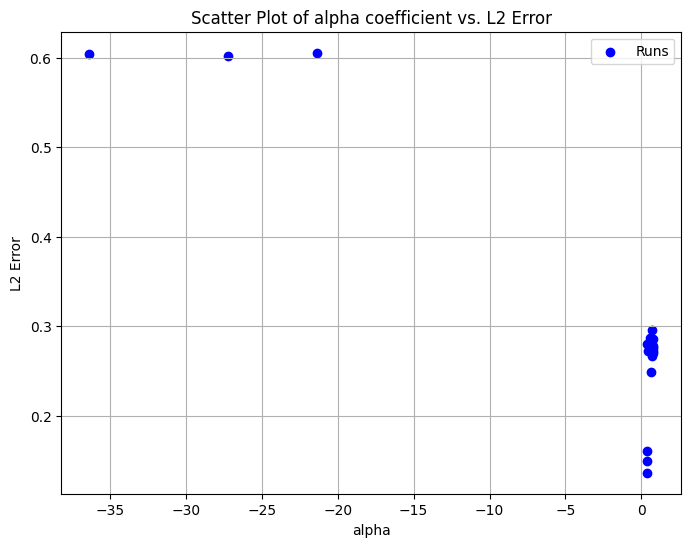

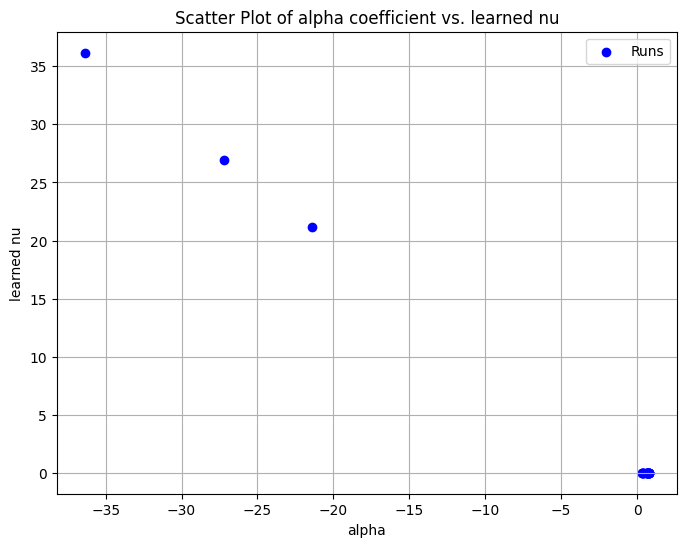

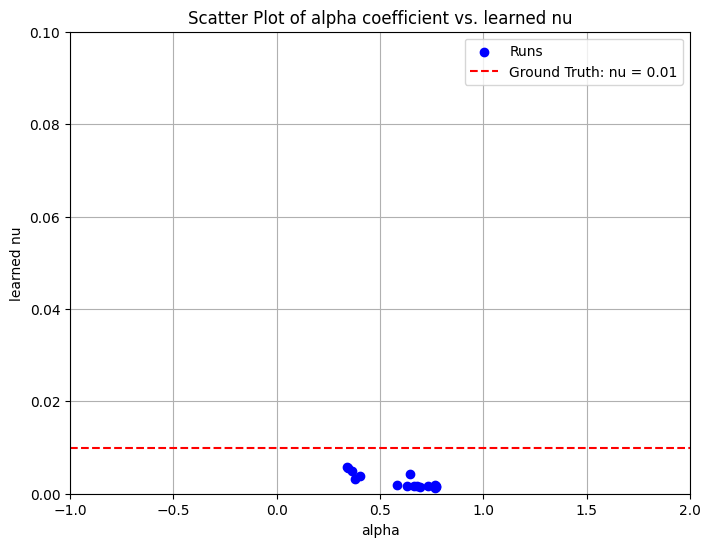

In [10]:
import matplotlib.pyplot as plt
print("alpha list:", alpha_list)
print("learned nu list:", learned_nu_list)
print("velocity l2 error:", l2_error_list)
plt.figure(figsize=(8, 6))
plt.scatter(alpha_list, l2_error_list, c='b', marker='o', label='Runs')
plt.xlabel('alpha')
plt.ylabel('L2 Error')
plt.title('Scatter Plot of alpha coefficient vs. L2 Error')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(alpha_list, learned_nu_list, c='b', marker='o', label='Runs')
plt.xlabel('alpha')
plt.ylabel('learned nu')
plt.title('Scatter Plot of alpha coefficient vs. learned nu')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(alpha_list, learned_nu_list, c='b', marker='o', label='Runs')
plt.axhline(y=0.01, color='r', linestyle='--', label='Ground Truth: nu = 0.01')

plt.xlabel('alpha')
plt.ylabel('learned nu')
plt.title('Scatter Plot of alpha coefficient vs. learned nu')
plt.legend()
# Limit the x and y label ranges
plt.xlim(-1, 2)  # Set the desired x-axis range
plt.ylim(0, 0.1)  # Set the desired y-axis range
plt.grid(True)
plt.show()

In [2]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                96        
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1185 (4.63 KB)
Trainable params: 1185 (4.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


exact_u shape: (256, 100)
u_star shape: (25600, 1)
u_star 2 shape: (100, 256)


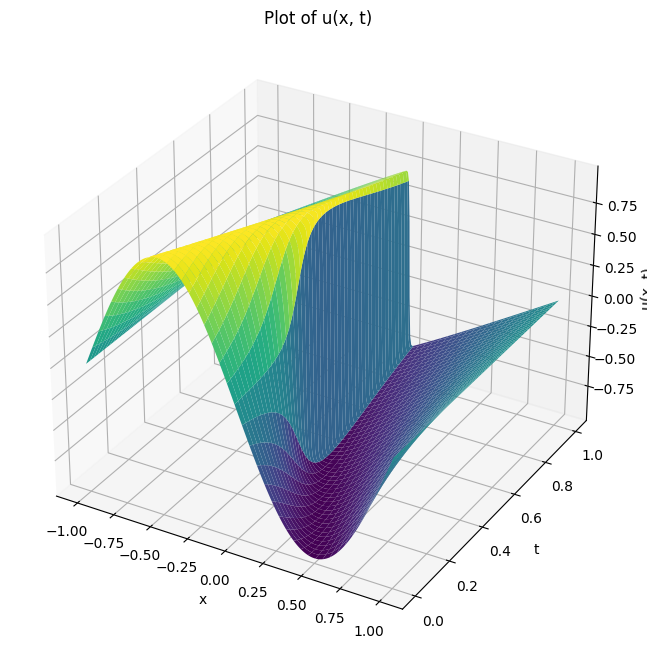

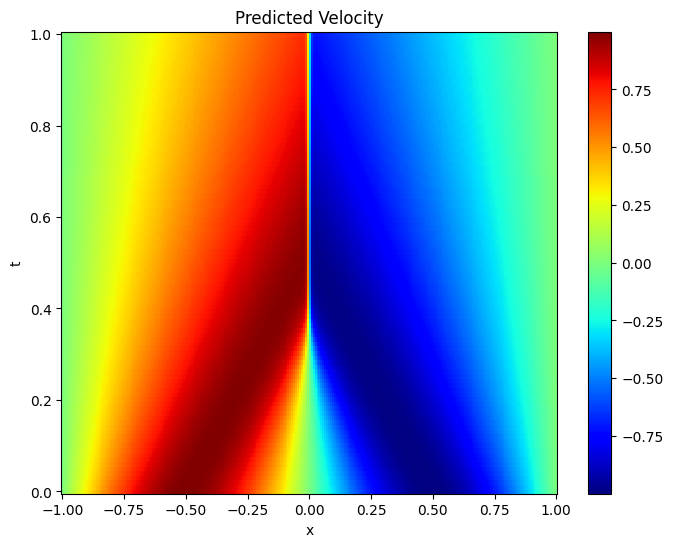

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'add', 'domain_ids', 'domaindict', 'time_var', 'vars']
800/800 [==============================] - 0s 282us/step
L2 error between predicted u and actual u: 0.13572522644530072


In [4]:
import scipy
import numpy as np
import tensorflow as tf

class DomainND:
    def __init__(self, var, time_var=None):
        self.vars = var
        self.domaindict = []
        self.domain_ids = []
        self.time_var = time_var

    # def generate_collocation_points(self, N_f):
    #     range_list = [
    #         [val for key, val in dict_.items() if "range" in key][0]
    #         for dict_ in self.domaindict
    #     ]

    #     limits = np.array(range_list)  # x,t domain
    #     X_f = LatinHypercubeSample(N_f, limits)
    #     self.X_f = X_f

    def add(self, token, vals, fidel):
        self.domain_ids.append(token)
        self.domaindict.append({
            "identifier": token,
            "range": vals,
            (token + "fidelity"): fidel,
            (token + "linspace"): np.linspace(vals[0], vals[1], fidel),
            (token + "upper"): vals[1],
            (token + "lower"): vals[0]
        })
        
DomainND = DomainND(["x", "t"], time_var='t')

DomainND.add("x", [-1.0, 1.0], 256)
DomainND.add("t", [0.0, 1.0], 100)

# input data
data = scipy.io.loadmat('burgers_shock.mat')
Exact = data['usol']
Exact_u = np.real(Exact) # shape of [256, 100]
x = DomainND.domaindict[0]['xlinspace']
t = DomainND.domaindict[1]["tlinspace"]

X, T = np.meshgrid(x, t)

# print(np.shape((X,T))) #2, 100, 256
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact_u.T.flatten()[:, None] # shape of [25600, 1]
print("exact_u shape:", Exact_u.shape)
print("u_star shape:", u_star.shape)
u_star_2 = griddata(X_star, u_star.flatten(), (X, T), method='cubic')
print("u_star 2 shape:", u_star_2.shape)

# Create a 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X, T, u_star_2, cmap='viridis')
# Set labels and title
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x, t)')
plt.title('Plot of u(x, t)')
plt.show()

# 2D plotting
plt.figure(figsize=(8, 6))
plt.pcolor(X, T, u_star_2, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted Velocity')
plt.show()

print(dir(DomainND))

u_pred_grid = model.predict(X_star)

l2_error = tf.sqrt(tf.reduce_mean(tf.square(u_pred_grid - u_star)))
print("L2 error between predicted u and actual u:", l2_error.numpy())



In [ ]:
# Save the entire model as a `.keras` zip archive.
# New high-level '.keras' format
# model.save('global_model.keras')


In [3]:
# v?? 19 Oct 2023 

# nu / np.pi yes
# batch_size [1024, 1024, 1024]
# lr = 0.005
# learned_nu at around 0.0001
# learnabe alpha

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import griddata

class Domain:
    def __init__(self, x_min, x_max, t_min, t_max, num_x, num_t, viscosity_init_v, batch_size, alpha_initial):
        self.x_min = x_min
        self.x_max = x_max
        self.t_min = t_min
        self.t_max = t_max
        self.num_x = num_x
        self.num_t = num_t
        self.batch_size_r = batch_size[0]
        self.batch_size_0 = batch_size[1]
        self.batch_size_b = batch_size[2]
        self.viscosity = tf.Variable(initial_value=viscosity_init_v, 
                                     trainable=True, 
                                     dtype=tf.float32,
                                     name="artificial_viscosity")
        self.alpha = tf.Variable(initial_value=tf.ones([]) * alpha_initial,
                                 trainable=False,
                                 dtype=tf.float32,
                                 name="nu_loss_coefficient")
    
# Define the initial condition
def initial_condition(domain, x):
    # initial_output = np.where(x > 0, 1, 0)
    initial_output = -np.sin(np.pi * x)
    return initial_output 

# Define the boundary conditions
def boundary_conditions(domain, x, t):
    return np.zeros_like(x)

# Define the physics-informed loss function
def physics_informed_loss(network, domain, x, t, batch_size):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)
        
        u = network(tf.concat([x, t], axis=1))

        u_x = tape.gradient(u, x) # cancel: Reshape x to [32,1]
        u_t = tape.gradient(u, t) # solved: u_t showed NoneType
        u_xx = tape.gradient(u_x, x)

        # Debugging: Check if any tensors contain NaN values
        tf.debugging.assert_all_finite(u_x, "u_x contains NaN values")
        tf.debugging.assert_all_finite(u_t, "u_t contains NaN values")

        # Define the Burgers equation residual
        residual = u_t + u * u_x - domain.viscosity * u_xx
    
    # Define the boundary and initial condition residuals # Done_TODO check "u" LR
    # Compute the loss for initial condition
    num_batch_size_0 = domain.batch_size_0
    t_batch_0 = tf.fill([num_batch_size_0, 1], 0.0001) # considered as 0
    x_batch_0 = tf.random.uniform([num_batch_size_0, 1], minval=domain.x_min, maxval=domain.x_max)
    u_0 = network(tf.concat([x_batch_0, t_batch_0], axis=1))
    initial_residual = u_0 - initial_condition(domain, x_batch_0)

    # Compute the loss for boundary condition
    num_batch_size_b = domain.batch_size_b
    x_batch_bl = tf.cast(tf.fill([num_batch_size_b, 1], -1), dtype=tf.float32)
    x_batch_br = tf.cast(tf.fill([num_batch_size_b, 1], 1), dtype=tf.float32)
    t_batch_b  = tf.random.uniform([num_batch_size_b, 1], minval=domain.t_min, maxval=domain.t_max)
    u_bl = network(tf.concat([x_batch_bl, t_batch_b], axis=1)) # int32 and float incompatible
    u_br = network(tf.concat([x_batch_br, t_batch_b], axis=1))
    lower_boundary_residual = u_bl - boundary_conditions(domain, x_batch_bl, t_batch_b)
    upper_boundary_residual = u_br - boundary_conditions(domain, x_batch_br, t_batch_b)

    viscosity_loss = tf.square(domain.viscosity) 

    loss = tf.reduce_mean(tf.square(residual)) / batch_size + \
           tf.reduce_mean(tf.square(initial_residual)) / num_batch_size_0 + \
           tf.reduce_mean(tf.square(lower_boundary_residual)) / num_batch_size_b + \
           tf.reduce_mean(tf.square(upper_boundary_residual)) / num_batch_size_b + \
            domain.alpha * viscosity_loss
    
    return loss

# Define the neural network model
def create_network():
    network = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(2,)),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    return network

# Train the model using PINNs
def train_model(network, domain, num_epochs, learning_rate):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Lists to store loss and viscosity values for each epoch
    history = [[] for _ in range(3)]  # Initialize history as a list with three empty lists
    # history components, [0]: loss, [1]: nu, [2]: alpha

    for epoch in range(num_epochs):
        x_batch = tf.random.uniform([domain.batch_size_r, 1], minval=domain.x_min, maxval=domain.x_max)
        t_batch = tf.random.uniform([domain.batch_size_r, 1], minval=domain.t_min, maxval=domain.t_max)

        with tf.GradientTape() as tape:
            loss = physics_informed_loss(network, domain, x_batch, t_batch, domain.batch_size_r)

        # add viscosity into the trainable variables from TF
        variable_list = network.trainable_variables + [domain.viscosity] # + [domain.alpha]

        gradients = tape.gradient(loss, variable_list)
        # # Update αvisc based on negative gradient
        # alpha_update = -learning_rate * gradients[-1]  # Negative gradient ascent
        # domain.alpha.assign_add(alpha_update)

        # # Apply gradients to the network weights
        # # optimizer.apply_gradients(zip(gradients[:-2], variable_list[:-2]))
        optimizer.apply_gradients(zip(gradients, variable_list))

        # if epoch % 100 == 0:
        #     print(f"Epoch {epoch}, Loss: {loss.numpy()}")

        if epoch % 10 == 0:
            # Append the loss and viscosity values to the history lists
            history[0].append(loss.numpy())
            history[1].append(domain.viscosity.numpy())
            history[2].append(domain.alpha.numpy())
    
    return network, history 

# Visualize the results
def visualize_results(model, domain, history, num_epochs):
    x_grid, t_grid = np.meshgrid(np.linspace(domain.x_min, domain.x_max, domain.num_x),
                                 np.linspace(domain.t_min, domain.t_max, domain.num_t))
    X = np.hstack((x_grid.flatten()[:, tf.newaxis], t_grid.flatten()[:, tf.newaxis]))
    u_pred_grid = model.predict(X)
    u_pred_grid = griddata(X, u_pred_grid.flatten(), (x_grid, t_grid), method='cubic')

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    ax.plot_surface(x_grid, t_grid, u_pred_grid, cmap='viridis')

    # Set labels and title
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u(x, t)')
    plt.title('Plot of u(x, t)')
    plt.show()

    # print("u_pred_shape:", u_pred_grid.shape)

    plt.figure(figsize=(8, 6))
    plt.pcolor(x_grid, t_grid, u_pred_grid, cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Predicted Velocity')
    plt.show()

    # Define the x-axis labels at intervals of every 10 epochs
    x_labels = list(range(0, num_epochs, 10))

    # Plot the loss and viscosity trajectories
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x_labels, history[0])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Trajectory')

    plt.subplot(1, 2, 2)
    plt.plot(x_labels, history[1])
    plt.axhline(y=0.01, color='r', linestyle='--', label='Ground Truth: nu = 0.01')
    plt.xlabel('Epoch')
    plt.ylabel('Viscosity')
    plt.title('Viscosity Trajectory')

    plt.figure(figsize=(6, 6))
    plt.plot(x_labels, history[2])
    plt.xlabel('Epoch')
    plt.ylabel('alpha')
    plt.title('Alpha Trajectory')

    plt.legend()
    plt.tight_layout()
    plt.show()
    return u_pred_grid


class DomainND:
    def __init__(self, var, time_var=None):
        self.vars = var
        self.domaindict = []
        self.domain_ids = []
        self.time_var = time_var

    # def generate_collocation_points(self, N_f):
    #     range_list = [
    #         [val for key, val in dict_.items() if "range" in key][0]
    #         for dict_ in self.domaindict
    #     ]

    #     limits = np.array(range_list)  # x,t domain
    #     X_f = LatinHypercubeSample(N_f, limits)
    #     self.X_f = X_f

    def add(self, token, vals, fidel):
        self.domain_ids.append(token)
        self.domaindict.append({
            "identifier": token,
            "range": vals,
            (token + "fidelity"): fidel,
            (token + "linspace"): np.linspace(vals[0], vals[1], fidel),
            (token + "upper"): vals[1],
            (token + "lower"): vals[0]
        })

if __name__ == "__main__":
    num_run = 10
    # create lists to store results for each run
    learned_nu_list = []
    l2_error_list = []
    alpha_list = []

        
    DomainND = DomainND(["x", "t"], time_var='t')

    DomainND.add("x", [-1.0, 1.0], 256)
    DomainND.add("t", [0.0, 1.0], 100)

    # input data
    data = scipy.io.loadmat('burgers_shock.mat')
    Exact = data['usol']
    Exact_u = np.real(Exact) # shape of [256, 100]
    x = DomainND.domaindict[0]['xlinspace']
    t = DomainND.domaindict[1]["tlinspace"]

    X, T = np.meshgrid(x, t)

    # print(np.shape((X,T))) #2, 100, 256
    X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    u_star = Exact_u.T.flatten()[:, None] # shape of [25600, 1]
    # print("exact_u shape:", Exact_u.shape)
    # print("u_star shape:", u_star.shape)
    # u_star_2 = griddata(X_star, u_star.flatten(), (X, T), method='cubic')
    # print("u_star 2 shape:", u_star_2.shape) 

    for run in range(num_run):
        # clear previous TensorFlow graph and session
        tf.keras.backend.clear_session()
        # tf.reset_default_graph() # no in tf v2.x
        
        # Define domain parameters and create the domain
        x_min = -1.0
        x_max = 1.0
        t_min = 0
        t_max = 1.00
        num_x = 256
        num_t = 100
        batch_size_r=1024
        num_batch_size_0 = 1024
        num_batch_size_b = 1024
        batch_size = [batch_size_r, num_batch_size_0, num_batch_size_b] # define batch_size list 
        viscosity_init_v = tf.random.uniform(shape=(), minval=0.001, maxval=1.0)
        num_epochs = 2000
        alpha_initial = np.linspace(0.06, 0.16, num_run)

        domain = Domain(x_min, x_max, t_min, t_max, num_x, num_t, viscosity_initha_i_v, batch_size, alpnitial[run])

        # Create the neural network 
        network = create_network()

        # Train the model using PINNs
        model, history = train_model(network, 
                                    domain, 
                                    num_epochs,
                                    learning_rate=0.01
                                    )

        # Visualize the results
        # u_pred_grid = visualize_results(model, domain, history, num_epochs)

        u_pred_grid_ND = model.predict(X_star)
        del model

        l2_error = tf.sqrt(tf.reduce_mean(tf.square(u_pred_grid_ND - u_star)))
        # print("L2 error between predicted u and actual u:", l2_error.numpy())
        # print("learned nu:", domain.viscosity.numpy)
        # print("alpha:", domain.alpha)
        # print("batch sizes:", batch_size)
        # print(f"Run {run + 1} - L2 error: {l2_error.numpy()}")
        print(f"Run {run + 1} finished.")

        # Store results in lists
        learned_nu_list.append(domain.viscosity.numpy())
        l2_error_list.append(l2_error.numpy())
        alpha_list.append(domain.alpha.numpy())

        # if hasattr(domain, 't_shock'):
        #     print("t_shock:", domain.t_shock)
        #     print("std_dev:", domain.std_dev)
        # else:
        #     print("Variables 't_shock' and 'std_dev' are not applicable in this AV method.")
    
    
    # Print the results for each run
    for run in range(num_run):
        print(f"Run {run + 1} - alpha: {alpha_list[run]} - Learned nu: {learned_nu_list[run]} - L2 error: {l2_error_list[run]}")

        


800/800 [==============================] - 0s 257us/step


Run 1 finished.
800/800 [==============================] - 0s 268us/step


Run 2 finished.
800/800 [==============================] - 0s 260us/step


Run 3 finished.
800/800 [==============================] - 0s 259us/step


Run 4 finished.
800/800 [==============================] - 0s 258us/step


Run 5 finished.
800/800 [==============================] - 0s 256us/step


Run 6 finished.
800/800 [==============================] - 0s 257us/step


Run 7 finished.
800/800 [==============================] - 0s 258us/step


Run 8 finished.
800/800 [==============================] - 0s 259us/step


Run 9 finished.
800/800 [==============================] - 0s 258us/step
Run 10 finished.
Run 1 - alpha: 0.05999999865889549 - Learned nu: 0.014070381410419941 - L2 error: 0.10717993068364852
Run 2 - alpha: 0.07111111283302307 - Learned nu: 0.01371185015887022 - L2 error: 0.11476430459009784
Run 3 - alpha: 0.08222222328186035 - Learned nu: 0.011439252644777298 - L2 error: 0.1095350418458851
Run 4 - alpha: 0.09333333373069763 - Learned nu: 0.011106501333415508 - L2 error: 0.11359468982372009
Run 5 - alpha: 0.10444444417953491 - Learned nu: 0.010649321600794792 - L2 error: 0.1396081602069199
Run 6 - alpha: 0.11555555462837219 - Learned nu: 0.01049716491252184 - L2 error: 0.12924072302810194
Run 7 - alpha: 0.12666666507720947 - Learned nu: 0.00855710543692112 - L2 error: 0.1295903457934668
Run 8 - alpha: 0.13777777552604675 - Learned nu: 0.010772365145385265 - L2 error: 0.13349428051485557
Run 9 - alpha: 0.14888888597488403 - Learned nu: 0.007878197357058525 - L2 error: 0.1344704659574774

alpha list: [0.06, 0.07111111, 0.08222222, 0.093333334, 0.104444444, 0.115555555, 0.12666667, 0.13777778, 0.14888889, 0.16]
learned nu list: [0.014070381, 0.01371185, 0.011439253, 0.011106501, 0.010649322, 0.010497165, 0.008557105, 0.010772365, 0.007878197, 0.0092198355]
velocity l2 error: [0.10717993068364852, 0.11476430459009784, 0.1095350418458851, 0.11359468982372009, 0.1396081602069199, 0.12924072302810194, 0.1295903457934668, 0.13349428051485557, 0.13447046595747747, 0.1501888931672243]


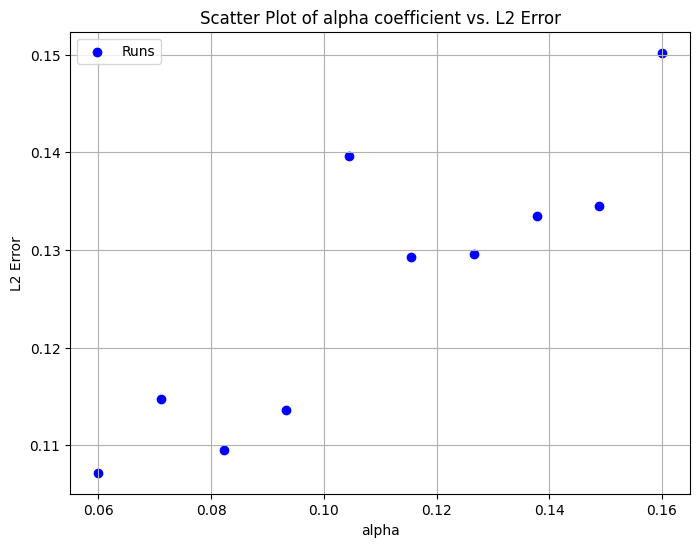

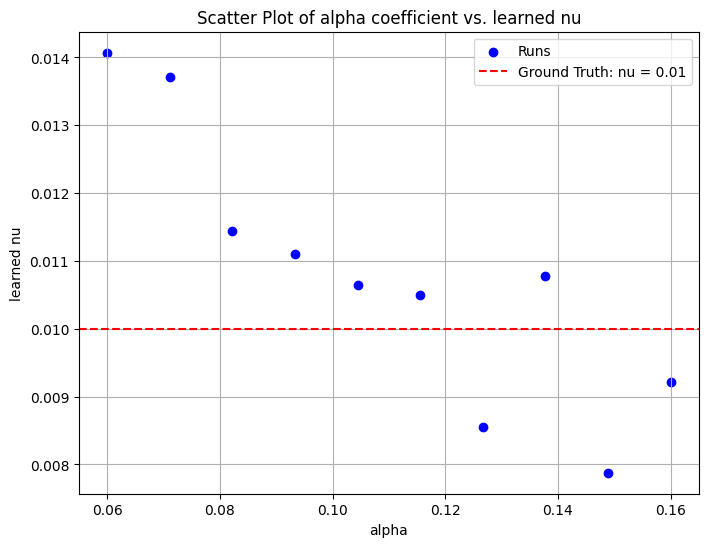

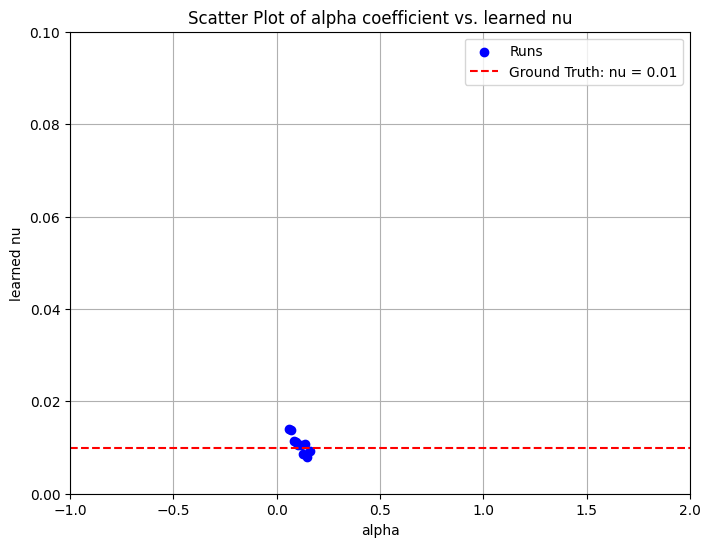

In [5]:
import matplotlib.pyplot as plt
print("alpha list:", alpha_list)
print("learned nu list:", learned_nu_list)
print("velocity l2 error:", l2_error_list)
plt.figure(figsize=(8, 6))
plt.scatter(alpha_list, l2_error_list, c='b', marker='o', label='Runs')
plt.xlabel('alpha')
plt.ylabel('L2 Error')
plt.title('Scatter Plot of alpha coefficient vs. L2 Error')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(alpha_list, learned_nu_list, c='b', marker='o', label='Runs')
plt.xlabel('alpha')
plt.ylabel('learned nu')
plt.title('Scatter Plot of alpha coefficient vs. learned nu')
plt.axhline(y=0.01, color='r', linestyle='--', label='Ground Truth: nu = 0.01')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(alpha_list, learned_nu_list, c='b', marker='o', label='Runs')
plt.axhline(y=0.01, color='r', linestyle='--', label='Ground Truth: nu = 0.01')

plt.xlabel('alpha')
plt.ylabel('learned nu')
plt.title('Scatter Plot of alpha coefficient vs. learned nu')
plt.legend()
# Limit the x and y label ranges
plt.xlim(-1, 2)  # Set the desired x-axis range
plt.ylim(0, 0.1)  # Set the desired y-axis range
plt.grid(True)
plt.show()